In [1]:
from datascience import *
import numpy as np

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In this lecture, I am going to use more interactive plots (they look better) so I am using the plotly.express library.  We won't test you on this but it's good to know.

In [3]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Lecture 10

## Review: Standard Units

**Task**
Convert the children's heights to standard units

In [4]:
family_heights = Table.read_table('data/family_heights.csv')
family_heights

family | father | mother | child | children | order | sex
1      | 78.5   | 67     | 73.2  | 4        | 1     | male
1      | 78.5   | 67     | 69.2  | 4        | 2     | female
1      | 78.5   | 67     | 69    | 4        | 3     | female
1      | 78.5   | 67     | 69    | 4        | 4     | female
2      | 75.5   | 66.5   | 73.5  | 4        | 1     | male
2      | 75.5   | 66.5   | 72.5  | 4        | 2     | male
2      | 75.5   | 66.5   | 65.5  | 4        | 3     | female
2      | 75.5   | 66.5   | 65.5  | 4        | 4     | female
3      | 75     | 64     | 71    | 2        | 1     | male
3      | 75     | 64     | 68    | 2        | 2     | female
... (924 rows omitted)

In [5]:
children_height = family_heights.column('child')
avg = np.mean(children_height)
std = np.std(children_height)
children_height_su = (children_height - avg) / std
family_heights.with_column('child su', children_height_su)

family | father | mother | child | children | order | sex    | child su
1      | 78.5   | 67     | 73.2  | 4        | 1     | male   | 1.80416
1      | 78.5   | 67     | 69.2  | 4        | 2     | female | 0.686005
1      | 78.5   | 67     | 69    | 4        | 3     | female | 0.630097
1      | 78.5   | 67     | 69    | 4        | 4     | female | 0.630097
2      | 75.5   | 66.5   | 73.5  | 4        | 1     | male   | 1.88802
2      | 75.5   | 66.5   | 72.5  | 4        | 2     | male   | 1.60848
2      | 75.5   | 66.5   | 65.5  | 4        | 3     | female | -0.348285
2      | 75.5   | 66.5   | 65.5  | 4        | 4     | female | -0.348285
3      | 75     | 64     | 71    | 2        | 1     | male   | 1.18917
3      | 75     | 64     | 68    | 2        | 2     | female | 0.350559
... (924 rows omitted)

## Predicting Child Heights

Recall, long ago, in lecture 10 we built a function to predict child heights.  We started with [Galton's height dataset](https://galton.org/essays/1880-1889/galton-1886-jaigi-regression-stature.pdf) which contained the full grown heigh of children and the height's of both of their parents. We then computed the average height of the parents of each child.

The following is the simplified version of the data containing just the parent's heights and the child height.

In [8]:
# Note: Child heights are the **adult** heights of children in a family
families = Table.read_table('data/family_heights.csv')
parent_avgs = (families.column('father') + families.column('mother'))/2
heights = Table().with_columns(
    'Parent Average', parent_avgs,
    'Child', families.column('child'),
)
heights

Parent Average | Child
72.75          | 73.2
72.75          | 69.2
72.75          | 69
72.75          | 69
71             | 73.5
71             | 72.5
71             | 65.5
71             | 65.5
69.5           | 71
69.5           | 68
... (924 rows omitted)

What was the relationship between height of the full grown child and the height of the parents?

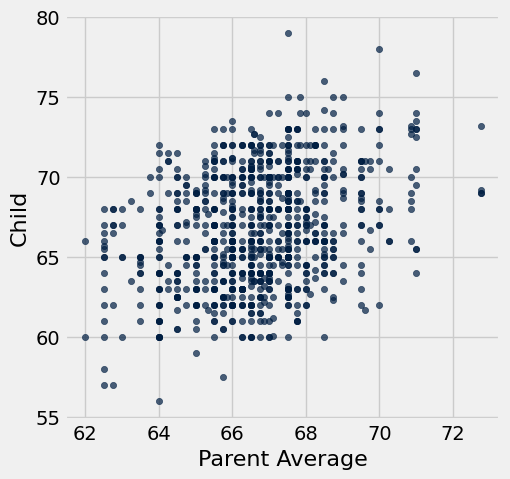

In [9]:
#heights.iscatter('Parent Average', 'Child')
heights.scatter('Parent Average', 'Child')

### The Nearest Neighbor Predictions

Could we use this data to help us predict the height of a newborn child given the parent's height? 

In lecture 10, we actually developed a highly sophisticated process for predicting the height of a child given the average heigh of both their parents.  We looked at children of parents with similar heights in our data and then took the average height of those nearby children.

In [10]:
def nearest_neighbor_predictor(parent_average, window=0.5):
    lower_bound = parent_average - window
    upper_bound = parent_average + window
    similar_child_heights = (
        heights
            .where("Parent Average", are.between(lower_bound, upper_bound))
            .column("Child")
    )
    return np.mean(similar_child_heights)

In [11]:
my_height = 5*12 + 11    # 5 ft 11 inches
spouse_height = 5*12 + 7 # 5 ft 7 inches
our_average = (my_height + spouse_height) / 2.0
our_average

69.0

In [12]:
window = 0.5
lower_bound = our_average - window
upper_bound = our_average + window
print(lower_bound, upper_bound)

68.5 69.5


In [13]:
nearest_neighbor_predictor(our_average)

67.988059701492531

In pictures, this nearest neighbor predictor looks like.

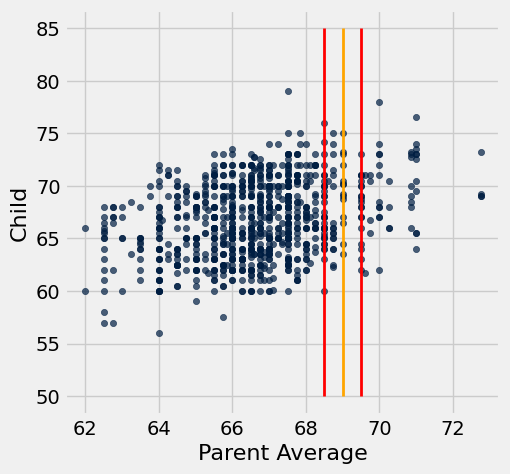

In [14]:
heights.scatter('Parent Average', 'Child')
# You don't need to know the details of this plotting code yet.
plots.plot([lower_bound, lower_bound], [50, 85], color='red', lw=2)
plots.plot([our_average, our_average], [50, 85], color='orange', lw=2);
plots.plot([upper_bound, upper_bound], [50, 85], color='red', lw=2);

In [15]:
# Interactive plot

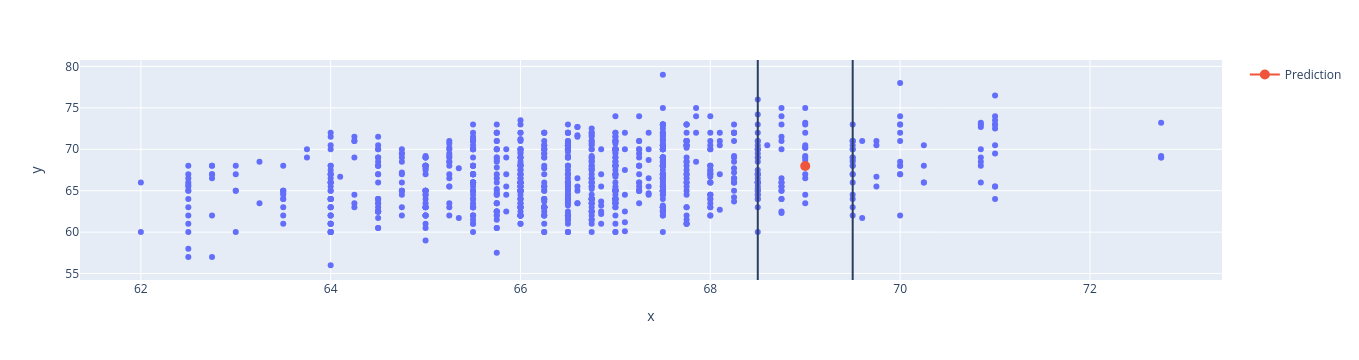

In [16]:
fig = px.scatter(x=heights.column('Parent Average'), y=heights.column('Child'))
fig.add_vline(our_average - 0.5)
fig.add_vline(our_average + 0.5)
fig.add_scatter(x=[our_average], y=[nearest_neighbor_predictor(our_average)], 
                name="Prediction", marker_size=10)

To get a sense as to how well our predictor works, we can apply it to each of the records in our dataset. Of course, we already know the height of the children for each of the records but this gives us a simple way to evaluate our predictions when we know the answer.

In [17]:
predicted_height = heights.apply(nearest_neighbor_predictor, 'Parent Average')
heights_with_predictions = heights.with_columns('Prediction', predicted_height)

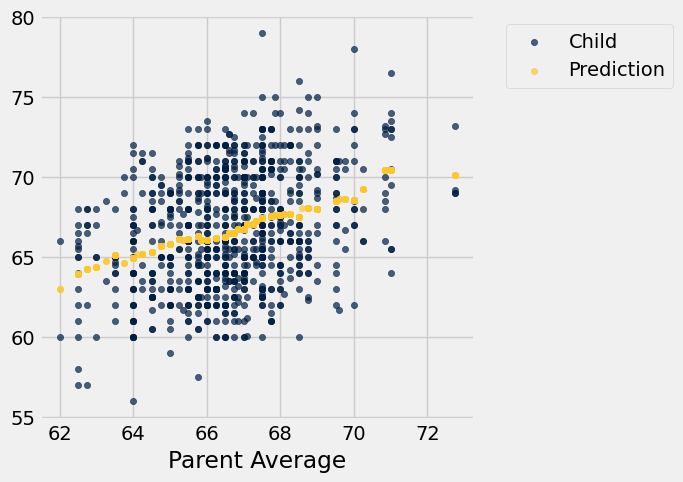

In [18]:
#heights_with_predictions.iscatter('Parent Average')
heights_with_predictions.scatter('Parent Average')

The yellow line above is not actually a line but a curve.  It is actually a fairly  advanced model capable of capturing complex non-linear relationships.  However, for many activities in data science we will be interested in a simple line that approximates the yellow curve. In this and the next few lectures we will build an intuition for the properties of this line and it's derivation. 

We still start with a mathematical description of the **linear association** between two variables: *a numerical measure of how closely two variables follow a line.*

---
<center>Return to Slides</center>

---

## Association

We already saw one example of an association between two variables:

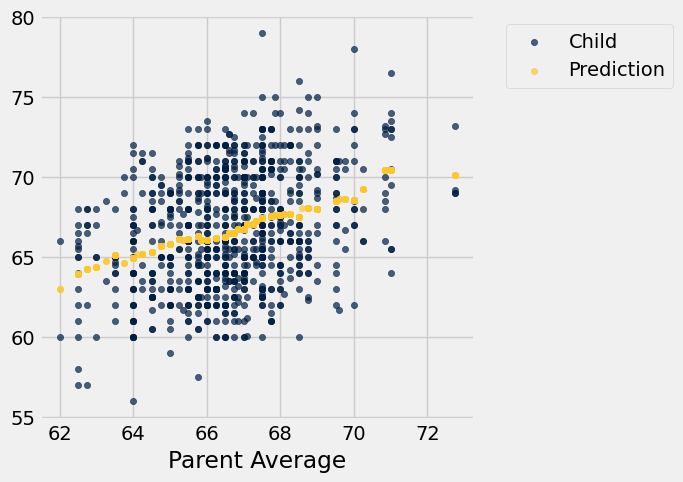

In [19]:
heights_with_predictions.scatter('Parent Average')

Let's look at another dataset consist of hybrid cars.  This dataset contains the vehicle model, the year it was released, the manufacturers suggested retail price (msrp), the acceleration (in km/h/s so bigger *is* better), fuel efficiency (mpg), and the type of car (class).

In [20]:
hybrid = Table.read_table('data/hybrid.csv')
hybrid.show(5)

There are some expensive hybrids...

In [21]:
hybrid.sort('msrp', descending=True)

vehicle         | year | msrp    | acceleration | mpg   | class
Lexus LS600h/hL | 2007 | 118544  | 17.54        | 21    | Midsize
ActiveHybrid 7  | 2010 | 104300  | 20.41        | 22.11 | Large
ActiveHybrid 7i | 2011 | 102606  | 18.18        | 20    | Midsize
ActiveHybrid X6 | 2009 | 97237.9 | 17.96        | 18.82 | SUV
S400 Long       | 2009 | 96208.9 | 13.89        | 26.34 | Large
Panamera S      | 2013 | 96150   | 18.52        | 25    | Large
Panamera S      | 2012 | 95283.9 | 17.54        | 25    | Large
S400            | 2013 | 92350   | 13.89        | 21    | Large
S400            | 2010 | 88212.8 | 12.99        | 21    | Large
ActiveHybrid 7L | 2013 | 84300   | 18.18        | 25    | Large
... (143 rows omitted)

The first step in studying an association is to visualize the data.

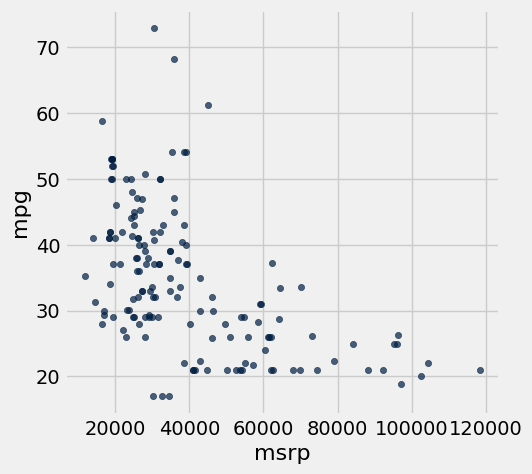

In [22]:
hybrid.scatter('msrp', 'mpg')

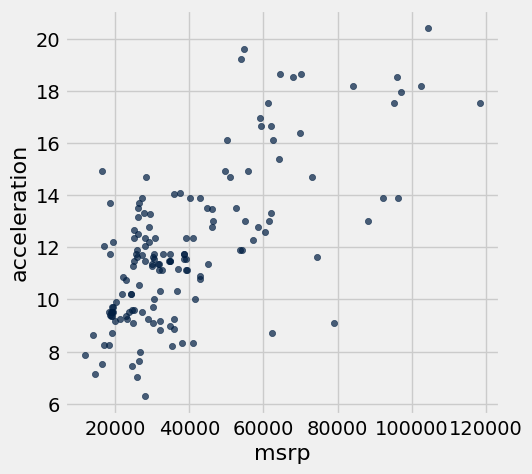

In [23]:
hybrid.scatter('msrp', 'acceleration')

We could even consider plotting at MPG, acceleration, and price all at once.

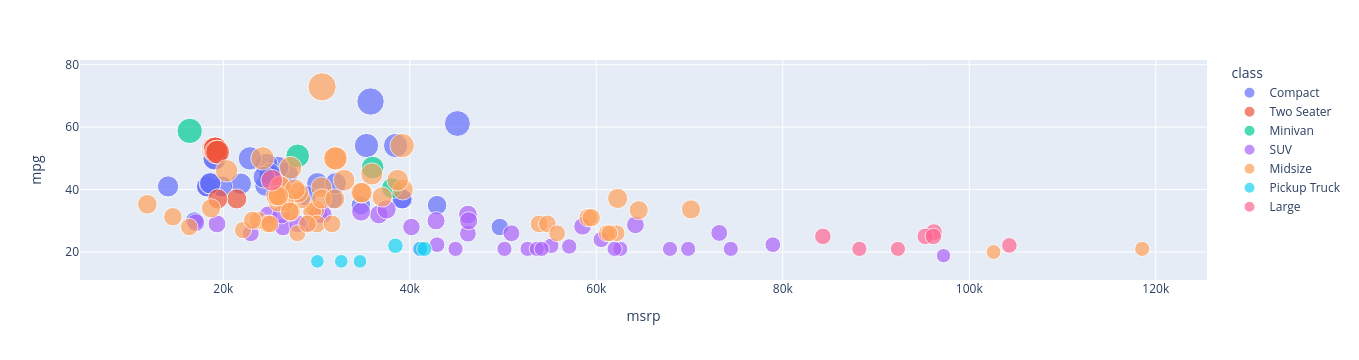

In [24]:
px.scatter(hybrid.to_df(), 
           x="msrp", 
           y="mpg", 
           size="mpg",
           hover_name="vehicle", 
           color="class")

What kinds of associations do we observe?

---
<center>Return to Slides</center>

---

## Correlation

Correlation is a measure of the linear relationship between two variables. Before we show you how to compute correlation, let's build an intuition for what it means.  To do that we will use the following helper function to generate data with different correlation values.

This is a helper function that generates and plots synthetic data with a given $r$ value. You are not expected to understand how this function works as it is well beyond the scope of this class.

In [25]:
def make_correlated_data(r, n=500):
    "Generate a a table with columns x and y with a correlation of approximately r"
    x = np.random.normal(0, 1, n)
    z = np.random.normal(0, 1, n)
    y = r*x + (np.sqrt(1-r**2))*z
    return Table().with_columns("x", x, "y", y)

def r_scatter(r, n=500, ax=None):
    plots.figure(figsize=(5,5))
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, n)
    z = np.random.normal(0, 1, n)
    y = r*x + (np.sqrt(1-r**2))*z
    if ax:        
        ax.scatter(x, y, color='darkblue', s=20)
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4) 
    else:
        plots.scatter(x, y, color='darkblue', s=20)
        plots.xlim(-4, 4)
        plots.ylim(-4, 4)    

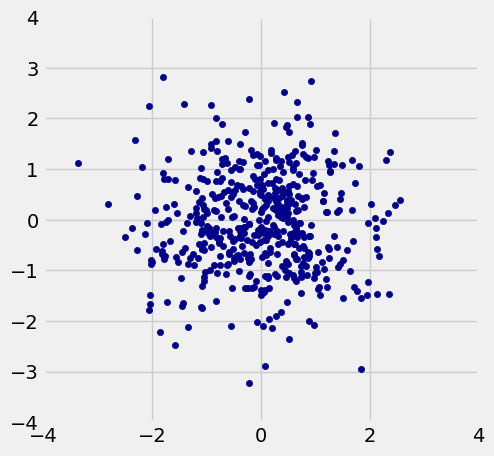

In [26]:
r_scatter(0.0)

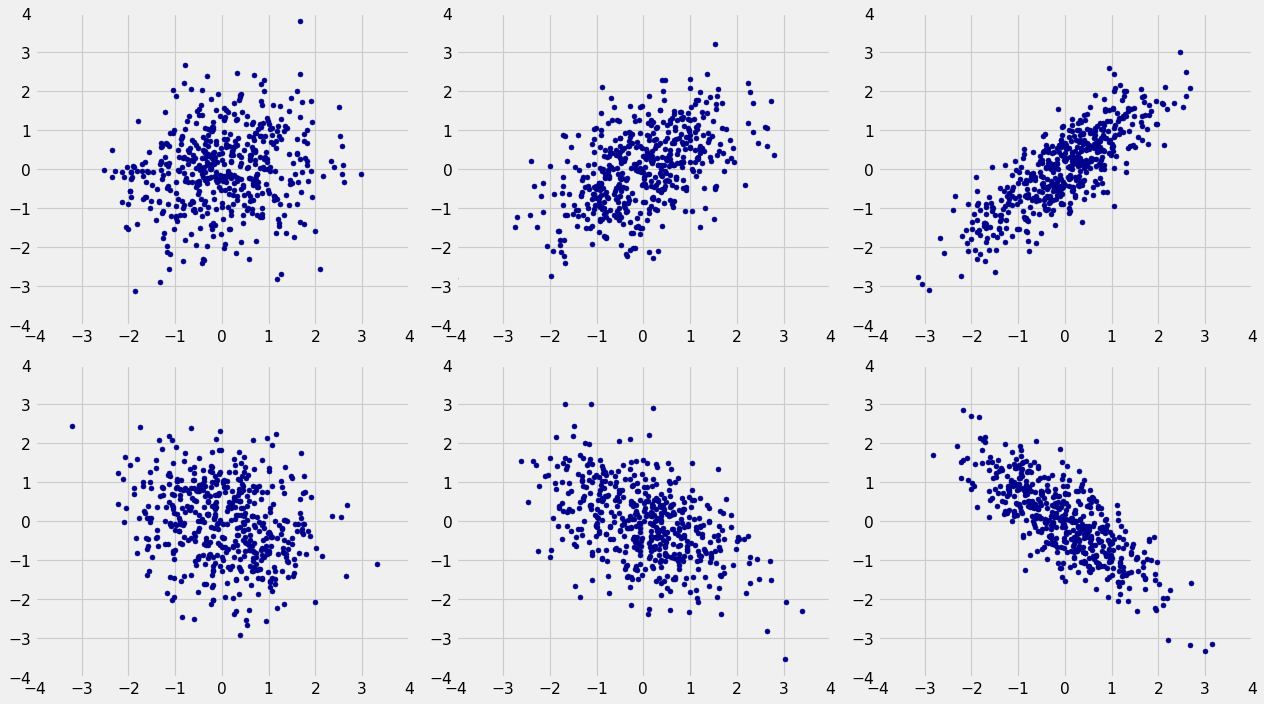

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [27]:
fig, ax = plots.subplots(2, 3, dpi=80, figsize=(16,9))
n = 500
r_scatter(0.2, n, ax[0,0])
r_scatter(0.5, n, ax[0,1])
r_scatter(0.8, n, ax[0,2])
r_scatter(-0.2, n, ax[1,0])
r_scatter(-0.5, n, ax[1,1])
r_scatter(-0.8, n, ax[1,2])
fig.tight_layout(pad=1)

### Computing the Correlation

To derive the correlation, we start by converting our data to standard units.

Recall in previous lectures we introduced a function to transform our data into standard units.

In [28]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x)) / np.std(x)

In [29]:
t = Table().with_columns('x', [1,2,3,4,5,6], 
                         'y', [1,3,3.2,5,5.1,7])
t

x    | y
1    | 1
2    | 3
3    | 3.2
4    | 5
5    | 5.1
6    | 7

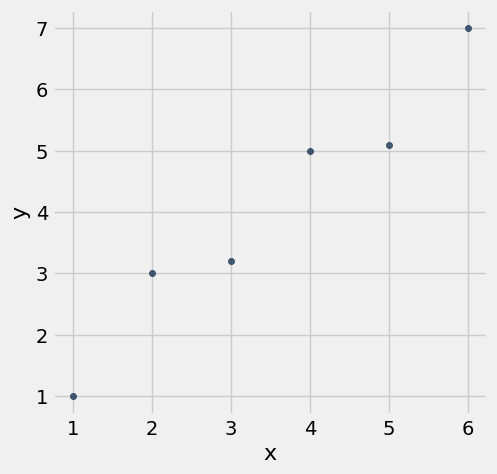

In [30]:
t.scatter('x', 'y')

**Question** 
What is the correlation coeffifient of those two variables?

between 0.9 and 1

**Tasks**
- add the standard units
- multiply the standard units of x and y for each row
- calculate the average of the products

-> The average of the products of the standard units IS the correlation coefficient

In [42]:
x_su = standard_units(t.column('x'))
y_su = standard_units(t.column('y'))
su_product = x_su * y_su

t.with_columns('x_su', x_su, 'y_su', y_su, 'su_product', su_product)

x    | y    | x_su     | y_su      | su_product
1    | 1    | -1.46385 | -1.59882  | 2.34043
2    | 3    | -0.87831 | -0.550413 | 0.483433
3    | 3.2  | -0.29277 | -0.445572 | 0.13045
4    | 5    | 0.29277  | 0.497992  | 0.145797
5    | 5.1  | 0.87831  | 0.550413  | 0.483433
6    | 7    | 1.46385  | 1.5464    | 2.26369

In [41]:
np.average(su_product)

0.97453930011049061

Lets add standard unit (SU) versions of the `mpg`, `msrp`, and `acceleration` to our hybrid table.

In [31]:
hybrid = hybrid.with_columns(
    "mpg (SU)", standard_units(hybrid.column('mpg')),
    "msrp (SU)", standard_units(hybrid.column('msrp')),
    "acceleration (SU)", standard_units(hybrid.column('acceleration')),
)
hybrid.show(5)

How does this change the plots?

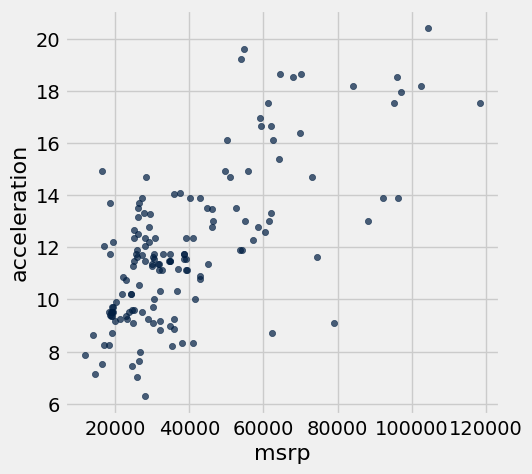

In [32]:
hybrid.scatter('msrp', 'acceleration')

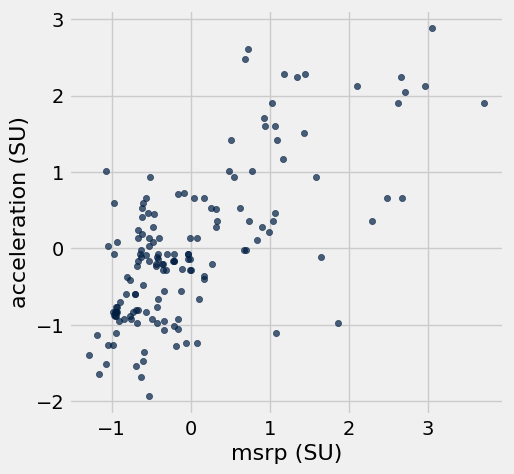

In [33]:
hybrid.scatter("msrp (SU)", "acceleration (SU)")

The correlation is the **average** of the **product** of the **standard units** of each variable.

\begin{align}
r & = \frac{1}{n}\sum_{i=1}^n \left( \frac{x_i - \text{Mean}(x)}{\text{Stdev}(x)} \right) * \left( \frac{y_i - \text{Mean}(y)}{\text{Stdev}(y)} \right) \\
 & = \frac{1}{n} \sum_{i=1}^n \text{StandardUnits}(x_i) *  \text{StandardUnits}(y_i)\\
 & = \text{Mean}\left(\text{StandardUnits}(x) *  \text{StandardUnits}(y)\right)
\end{align}


In [34]:
np.mean(hybrid.column("acceleration (SU)") * hybrid.column("msrp (SU)"))

0.69557789969139783

A positive correlation close to 1 would mean that when acceleration is larger than the mean then msrp should also be larger than the mean.  Looking at the histogram of the product we see:

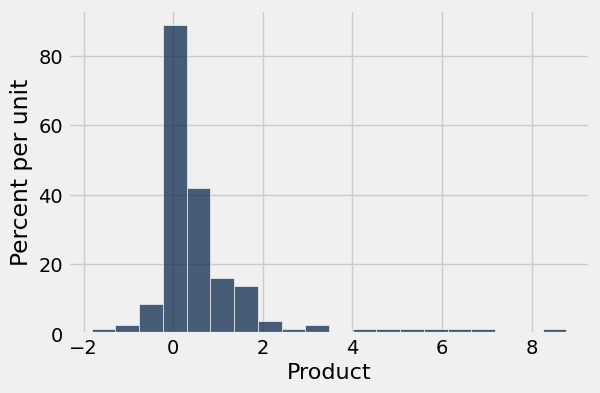

In [35]:
Table().with_column("Product", hybrid.column("acceleration (SU)") * hybrid.column("msrp (SU)")).hist("Product", bins=20)

### Defining the Correlation Function

Let's define a function that computes the correlation between two columns in a table.

In [44]:
def correlation(t, x, y):
    """t is a table; x and y are column labels"""
    x_in_su = standard_units(t.column(x))
    y_in_su = standard_units(t.column(y))
    return np.mean(x_in_su * y_in_su)

Can you guess the value of the correlation for each of the following relationships:

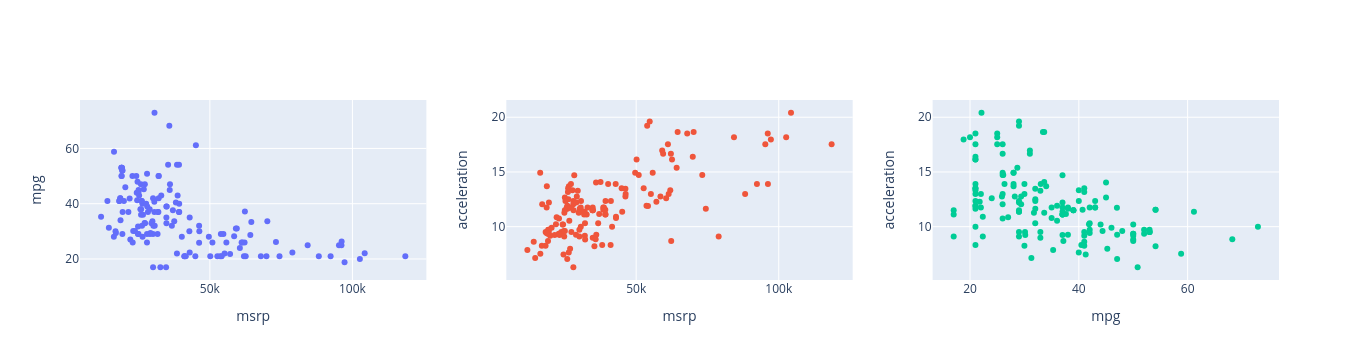

In [36]:
fig = make_subplots(1,3)
fig.add_scatter(x=hybrid.column("msrp"), y=hybrid.column("mpg"), mode="markers", row=1, col=1)
fig.add_scatter(x=hybrid.column("msrp"), y=hybrid.column("acceleration"), mode="markers", row=1, col=2)
fig.add_scatter(x=hybrid.column("mpg"), y=hybrid.column("acceleration"), mode="markers", row=1, col=3)
fig.update_xaxes(title_text="msrp", row=1, col=1)
fig.update_yaxes(title_text="mpg", row=1, col=1)
fig.update_xaxes(title_text="msrp", row=1, col=2)
fig.update_yaxes(title_text="acceleration", row=1, col=2)
fig.update_xaxes(title_text="mpg", row=1, col=3)
fig.update_yaxes(title_text="acceleration", row=1, col=3)
fig.update_layout(showlegend=False)

In [45]:
correlation(hybrid, "msrp", "mpg")

-0.53182636336837863

In [46]:
correlation(hybrid, "msrp", "acceleration")

0.69557789969139783

In [47]:
correlation(hybrid, "mpg", "acceleration")

-0.5060703843771186

### Switching Axes

What happens if we swap the axes?

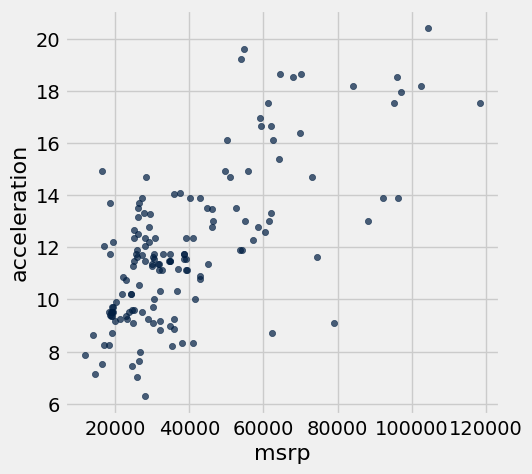

In [48]:
hybrid.scatter("msrp", "acceleration")

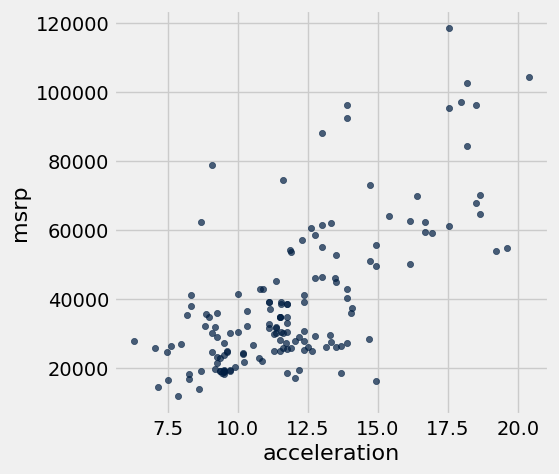

In [49]:
hybrid.scatter("acceleration", "msrp")

In [50]:
correlation(hybrid, "msrp", "acceleration")

0.69557789969139783

In [51]:
correlation(hybrid, "acceleration", "msrp")

0.69557789969139783

<details><summary>Solution</summary>

Switching axes doesn't affect the correlation.  It is a symmetric function.

</details>

---

<center>Return to Slides</center>

---

## Care when Interpreting Correlation

When computing correlation it is important to always visualize your data first and then consider each of the following issues.


### Correlation does Not Imply Causation

We have covered this one extensively at this point.  

### Nonlinearity

Low correlation does not imply absence of a relationship. Correlation measures linear relationships.  Data with strong non-linear relationship may have very low correlation.  

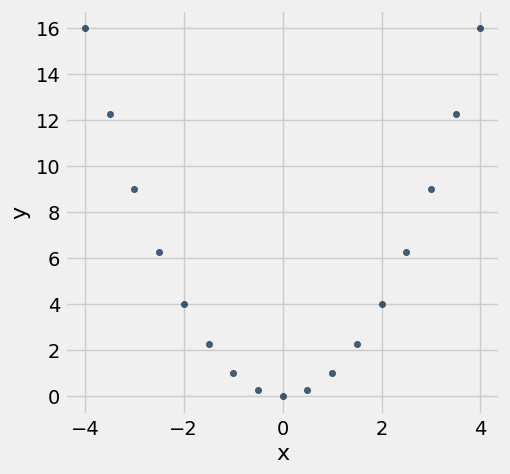

In [52]:
new_x = np.arange(-4, 4.1, 0.5)
nonlinear = Table().with_columns('x', new_x, 'y', new_x**2)
nonlinear.scatter('x', 'y')

There is clearly a relationship to this data.  Given the value of $x$ you can easily predict the value of $y$.  What is the correlation?

In [53]:
correlation(nonlinear, 'x', 'y')

0.0

As a quick aside, how would our nearest neighbor predictor work on this non-linear data.

In [54]:
def nn_predictor(x):
    return np.mean(nonlinear.where("x", are.between(x-0.51, x+0.51)).column("y"))

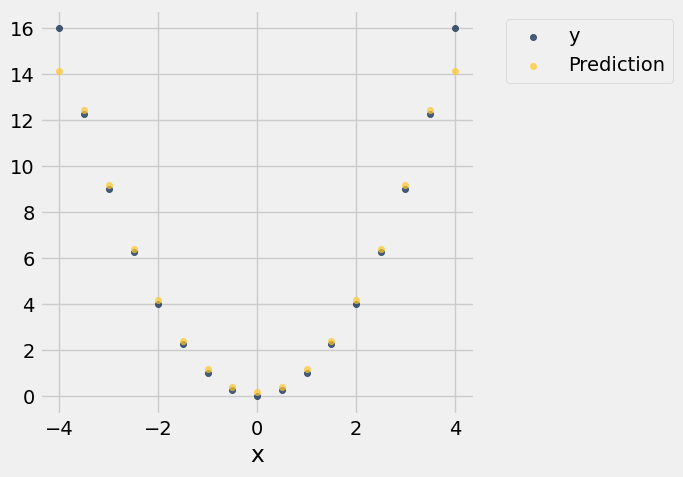

In [55]:
nonlinear.with_column("Prediction", nonlinear.apply(nn_predictor, "x")).scatter("x")

### Outliers

Outliers can have a significant effect on correlation.  

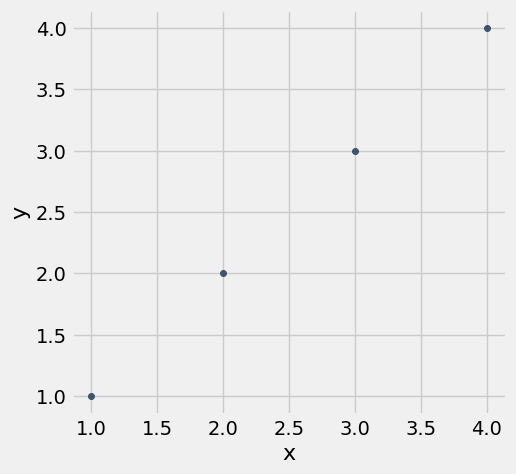

In [56]:
line = Table().with_columns(
        'x', make_array(1, 2, 3, 4),
        'y', make_array(1, 2, 3, 4)
    )
line.scatter('x', 'y')

In [57]:
correlation(line, 'x', 'y')

1.0

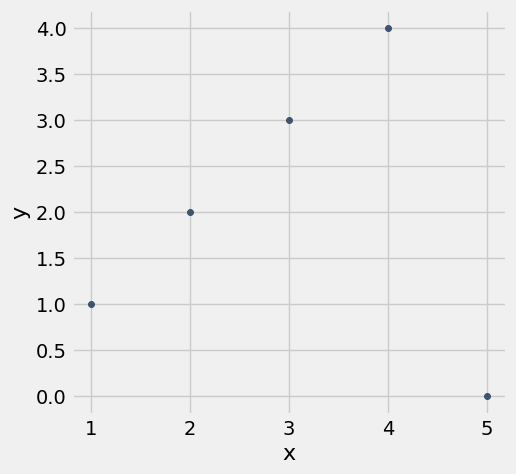

In [58]:
outlier = Table().with_columns(
        'x', make_array(1, 2, 3, 4, 5),
        'y', make_array(1, 2, 3, 4, 0)
    )
outlier.scatter('x', 'y')

In [59]:
correlation(outlier, 'x', 'y')

0.0

### Ecological Correlations

The correlation between aggregated variables (e.g., after grouping) may be much higher than the correlation between the underlying variables.

In [60]:
sat2014 = Table.read_table('data/sat2014.csv').sort('State')
sat2014

State                | Participation Rate | Critical Reading | Math | Writing | Combined
Alabama              | 6.7                | 547              | 538  | 532     | 1617
Alaska               | 54.2               | 507              | 503  | 475     | 1485
Arizona              | 36.4               | 522              | 525  | 500     | 1547
Arkansas             | 4.2                | 573              | 571  | 554     | 1698
California           | 60.3               | 498              | 510  | 496     | 1504
Colorado             | 14.3               | 582              | 586  | 567     | 1735
Connecticut          | 88.4               | 507              | 510  | 508     | 1525
Delaware             | 100                | 456              | 459  | 444     | 1359
District of Columbia | 100                | 440              | 438  | 431     | 1309
Florida              | 72.2               | 491              | 485  | 472     | 1448
... (41 rows omitted)

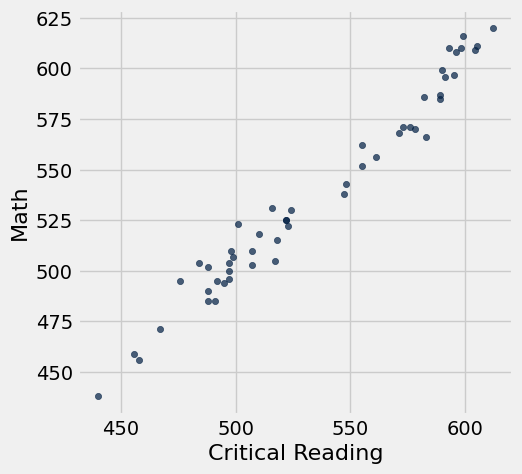

In [61]:
sat2014.scatter('Critical Reading', 'Math')

In [62]:
correlation(sat2014, 'Critical Reading', 'Math')

0.98475584110674341

That is a very strong correlation.  However, each data point corresponds to a large cloud of data points where each person might have had greater variability in their scores.  

### Bonus: Understanding the SAT data
While we have the data loaded.  Does anyone have a guess which dots correspond to which state?

In [63]:
def rate_code(x):
    if x<25:
        return 'low'
    elif x<50:
        return 'low-moderate'
    elif x<75: 
        return 'moderate-high'
    else:
        return 'high'
    
rate_codes = sat2014.apply(rate_code, 'Participation Rate')
sat2014 = sat2014.with_column('Rate Code', rate_codes)
sat2014

State                | Participation Rate | Critical Reading | Math | Writing | Combined | Rate Code
Alabama              | 6.7                | 547              | 538  | 532     | 1617     | low
Alaska               | 54.2               | 507              | 503  | 475     | 1485     | moderate-high
Arizona              | 36.4               | 522              | 525  | 500     | 1547     | low-moderate
Arkansas             | 4.2                | 573              | 571  | 554     | 1698     | low
California           | 60.3               | 498              | 510  | 496     | 1504     | moderate-high
Colorado             | 14.3               | 582              | 586  | 567     | 1735     | low
Connecticut          | 88.4               | 507              | 510  | 508     | 1525     | high
Delaware             | 100                | 456              | 459  | 444     | 1359     | high
District of Columbia | 100                | 440              | 438  | 431     | 1309     | high
Florida              | 72.2               | 491              | 485  | 472     | 1448     | moderate-high
... (41 rows omitted)

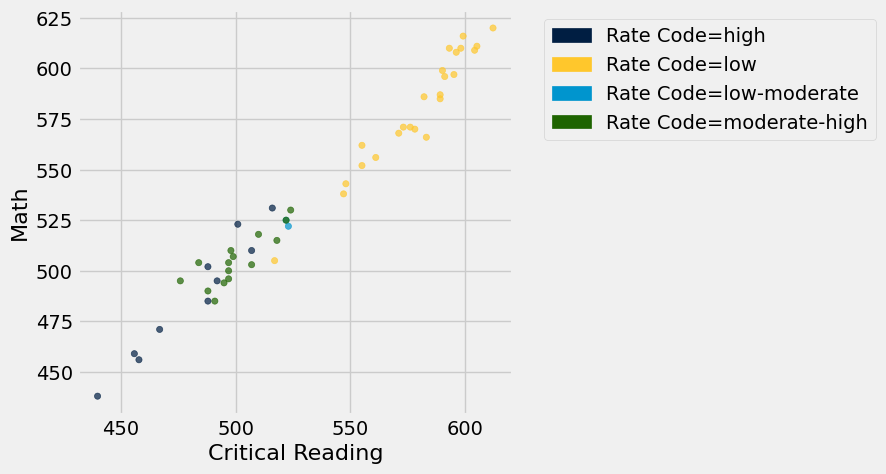

In [64]:
sat2014.scatter('Critical Reading', 'Math', group='Rate Code')

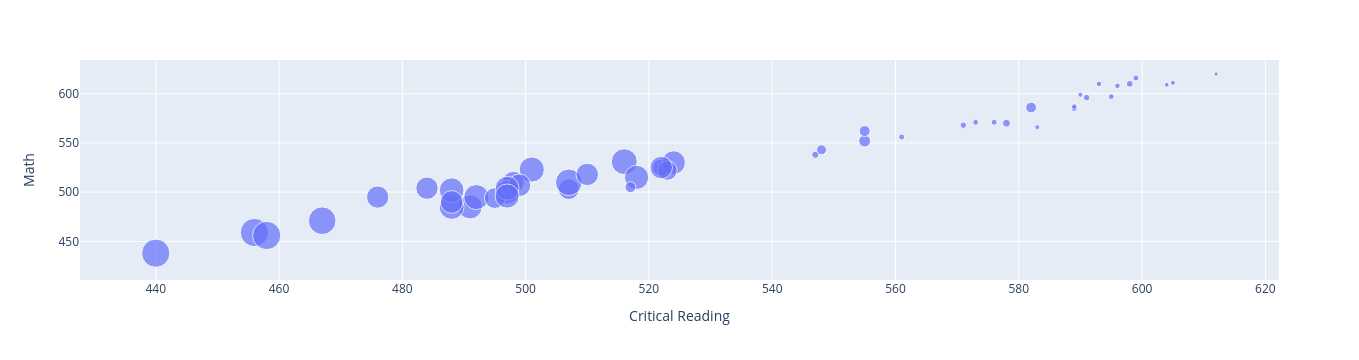

In [65]:
px.scatter(sat2014.to_df(), 
           x = "Critical Reading",
           y = "Math",
           hover_name = "State",
           size = "Participation Rate")